# Sensor Data Fusion
Lecturer: Prof. Baum \
Tutor: Kolja Thormann \
Semester: Winter 21/22
## Homework 9

Assume a robot in 2D-space at position $\begin{bmatrix}x_1 & x_2\end{bmatrix}^T$ moving with velocity $v_1$ in $x_1$ direction and $v_2$ in $x_2$ direction. Its state is defined as $\textbf{x}=\begin{bmatrix}x_1 & x_2 & v_1 & v_2\end{bmatrix}^T$.

---
The following tasks will have missing sections marked that you should fill out. 

Missing code parts are marked by
```
# ... code code code
=== YOUR CODE HERE ===

=== END OF YOUR CODE ===
# ... code code code
```
If you are asked to implement a function, make sure to check what variable will be returned by the function and to fill it accordingly. Do not change code outside of the indicated sections.

Furthermore, some questions require theoretical answers instead of python code.

Such questions will have a field marked like this: 

=== YOUR ANSWER HERE === 

In [77]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy.linalg import inv

In [78]:
# variable definitions

t = 1  # length of a time step
steps = 10  # number of steps to run simulation for
x_init = np.array([0, 0, 2, 2])  # inital mean for x

# transition noise matrix
Q = np.array([  
        [0.01, 0, 0, 0],
        [0, 0.01, 0, 0],
        [0, 0, 0.2, 0],
        [0, 0 ,0, 0.2]
    ])

# measurement noise matrix
R = np.array([
    [0.2, 0],
    [0, 0.2]
])

# inital covariance for x
# x_cov (=C_init) is just np.eye, but incase you want to try different values, change them here:
x_cov = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

---
### a)

Formulate a motion model for the robot, assuming independent zero-mean Gaussian noise on each state element. Write a function implementing the motion model.

In general, the motion model will look like this:

$$
\textbf{x}_{k+1}=\textbf{F}\textbf{x}_k+\nu\text{, with }\nu\sim\mathcal{N}(0, \textbf{Q})
$$


You will now need to define the state transition matrix $\textbf{F}$.\
Keep in mind that it should make use of the variable `t` defined above, which indicates the length of a time step (default: `t = 1`s)

In [79]:
# define F

# === YOUR CODE HERE ===
# F = ...
F = [
    [1, 0, t, 0],
    [0, 1, 0, t],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
]

# === END OF YOUR CODE ===

F = np.array(F)
# make sure F is of the correct shape
assert F.shape ==  (4,4)

# Q will be defined later

Next, you need to implement the motion model. The function will be passed $\textbf{Q}$ and $\textbf{F}$.

Hint: for multivariate normal distributions, numpy provides `np.random.multivariate_normal`

In [80]:
def motion_model(x, Q, F):
    """
    Function that implements the motion model.
    :param x: current state
    :param Q: transition noise matrix
    :param F: state transition matrix
    :return: x_new, the new state
    """
    x = np.array(x)
    Q = np.array(Q)
    
    # === YOUR CODE HERE ===
    
    x_new = F @ x + np.random.multivariate_normal(np.zeros(x.shape[0]), Q)
    
    # === END OF YOUR CODE ===
    
    return x_new


# Test the function:
x_test = [10, 10, 1, 2]  
print(motion_model(x_test, Q , F))

[10.81709409 11.91627307  0.39900314  2.17462811]


---
### b)
In each time step, a sensor measures the robot's position. Formulate a measurement equation assuming independent zero-mean Gaussian noise and implement it as well.

In general, the measuremen equation will look like this:
$$
y=\textbf{H}\textbf{x}_k + \mu\text{, with }\mu\sim\mathcal{N}(0, \textbf{R})
$$


You will now need to define the measuremement matrix $\textbf{H}$.

In [81]:
# define H

# === YOUR CODE HERE ===
# H = ...
H = [
    [1, 0, 0, 0],
    [0, 1, 0, 0],
]

# === END OF YOUR CODE ===

H = np.array(H)
# make sure F is of the correct shape
assert H.shape ==  (2,4)

In [82]:
def measurement_model(x, H, R):
    """
    Function that implements the measurement model.
    :param x: current state
    :param R: measurement noise matrix
    :return: y, the measurement
    """
    R = np.array(R)
    H = np.array(H)
    
    # === YOUR CODE HERE ===
    
    y = H @ x + np.random.multivariate_normal(np.zeros(H.shape[0]), R)
    
    # === END OF YOUR CODE ===
    
    return y

# Test the function:
x_test = [10, 10, 1, 2] 
print(measurement_model(x_test, H, R))

[ 9.51102459 10.29274002]


---
### c)
Use the functions from a) and b) to implement a simulation using initial state $\hat{\textbf{x}}_{\text{init}}=\begin{bmatrix}0\text{m} & 0\text{m} & 2\text{ms}^{-1} & 2 \text{ms}^{-1}\end{bmatrix}$, 10 time steps of length 1s, and covariances for the initial state $\textbf{C}_{\text{init}}$, the transition noise $\textbf{Q}$ and the measurement noise $\textbf{R}$ as
$$
\textbf{C}_{\text{init}}=\begin{bmatrix}1 & 0 & 0 & 0\\0 & 1 & 0 & 0\\0 & 0 & 1 & 0\\0 & 0 & 0 & 1\end{bmatrix}, \textbf{Q}=\begin{bmatrix}0.01 & 0 & 0 & 0\\0 & 0.01 & 0 & 0\\0 & 0 & 0.2 & 0\\0 & 0 & 0 & 0.2\end{bmatrix}\text{, }\textbf{R}=\begin{bmatrix}0.2 & 0\\0 & 0.2\end{bmatrix}\enspace.
$$

For each run, draw the true state from the prior, i.e. using $\hat{\textbf{x}}_{\text{init}}$ and $\textbf{C}_{\text{init}}$!

In [83]:
def simulation(x_init, x_init_cov, Q, R, H, F, steps):
    """
    :param x_init: Initial state
    :param x_init_cov: Initial state covariance matrix
    :param Q: Transition noise matrix
    :param R: Measurement noise matrix
    :param F: state transition matrix
    :param H: measurement matrix
    :param steps: Number of steps to run the simulation for
    :return: (track, ms) with track being the ground truth track, and ms the measurements produced in the simulation.
    """
    x_dim = len(x_init)
    
    # === YOUR CODE HERE ===
    
    track = []
    ms = []

    x_hat = motion_model(x_init, Q, F)
    track.append(x_hat)

    for i in range(steps - 1):
        x_hat = motion_model(x_hat, Q, F)
        track.append(x_hat)
        ms.append(measurement_model(x_hat, H, R))
    
    track = np.array(track)
    ms = np.array(ms)

    # === END OF YOUR CODE ===
    
    # track should have "steps" many entries of states of correct dimension
    assert track.shape == (steps, x_dim)  
    
    # one less measurement (no measurement for the initial state) and measurements are of dim len(R)
    assert ms.shape == (steps-1, R.shape[0])  
    
    return track, ms

# simulate track and measurements based on the values defined above
gt, ms = simulation(x_init, x_cov, Q, R, H, F, steps)

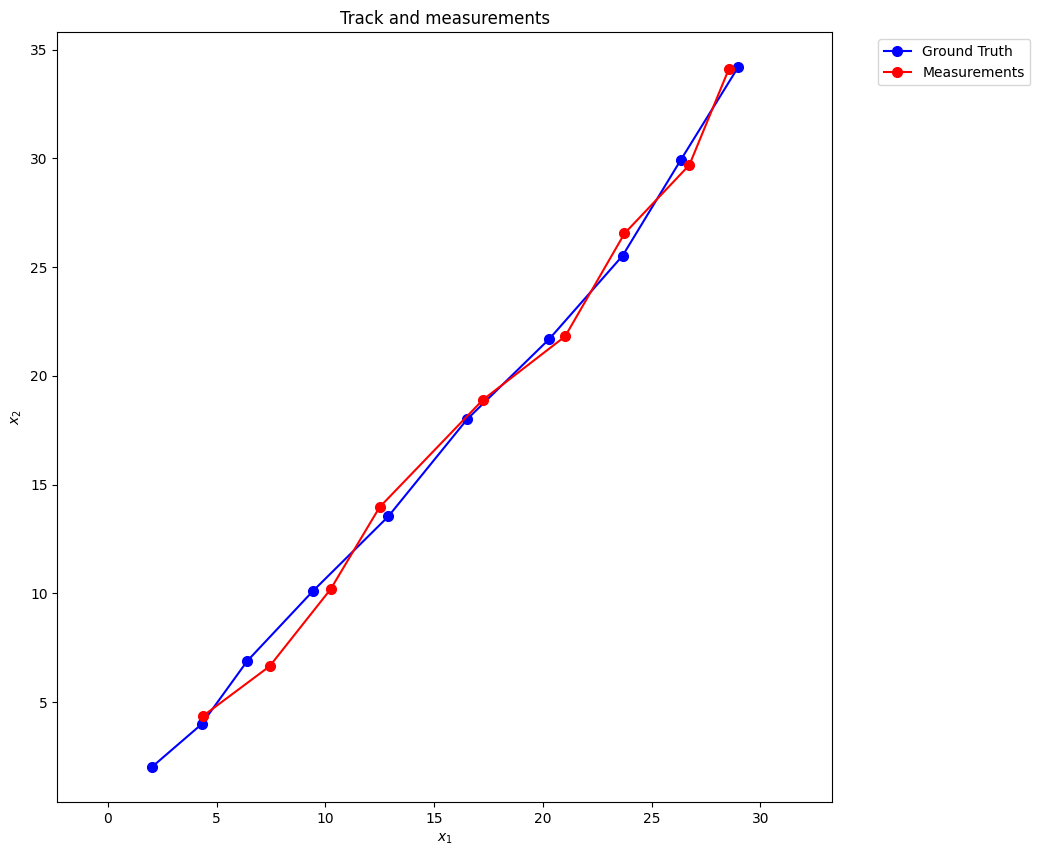

In [84]:
# Visualize the results of the simulation:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(gt[:, 0], gt[:, 1], c="b", label="Ground Truth", markersize=7, marker="o")
ax.plot(ms[:, 0], ms[:, 1], c="r", label="Measurements", markersize=7, marker="o")

ax.axis("equal")
plt.title("Track and measurements")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

---
### d)
Now based on a) and b), implement a predict and an update function for a Kalman filter. Use the Kalman filter to track the robot simulated with your function from c).

In [85]:
def predict(x, x_cov, Q, F):
    """
    Function that implements the predict step of a Kalman Filter.
    :param x: Current state
    :param x_cov: Current state covariance matrix
    :param Q: Transition noise matrix
    :param F: state transition matrix
    :return: (x_new, x_cov_new) The resulting state and covariance matrix after the predict step
    """
    
    # === YOUR CODE HERE ===
    
    x_new = F @ x
    x_cov_new = F @ x_cov @ F.T + Q
    
    # === END OF YOUR CODE ===
    
    return x_new, x_cov_new

In [86]:
def update(x, x_cov, m, H, R):
    """
    Function that implements the update step of a Kalman Filter.
    :param x: Current state
    :param x_cov: Current state covariance matrix
    :param m: Measurement
    :param H: measurement matrix
    :param R: Measurement noise matrix
    :return: (x_new, x_cov_new) The resulting state and covariance matrix after the update step
    """

    # === YOUR CODE HERE ===
    
    K = x_cov @ H.T @ np.linalg.inv(H @ x_cov @ H.T + R)
    x_new = x + K @ (m - H @ x)
    x_cov_new = x_cov - K @ H @ x_cov
    
    # === END OF YOUR CODE ===
    
    return x_new, x_cov_new

In [87]:
def kalman_filter(x_init, x_cov, ms, Q, R, H, F):
    """
    Function that runs the predict and update steps of a kalman filter.
    :param x_init: Initial state
    :param x_cov: Initial state covariance matrix
    :param ms: Measurements 
    :param Q: transition noise matrix
    :param R: Measurement noise matrix
    :param H: measurement matrix
    :param F: state transition matrix
    :return: track, the resulting track after applying the kalman filter
    """
    # initial track
    track = np.zeros((ms.shape[0]+1,x_init.shape[0]))
    track[0, :] = x_init
    
    for i in range(1, ms.shape[0]+1):
        track[i, :], x_cov = predict(track[i-1, :].T, x_cov, Q, F)
        track[i, :], x_cov = update(track[i, :].T, x_cov, ms[i-1, :].T, H, R)
    
    return track

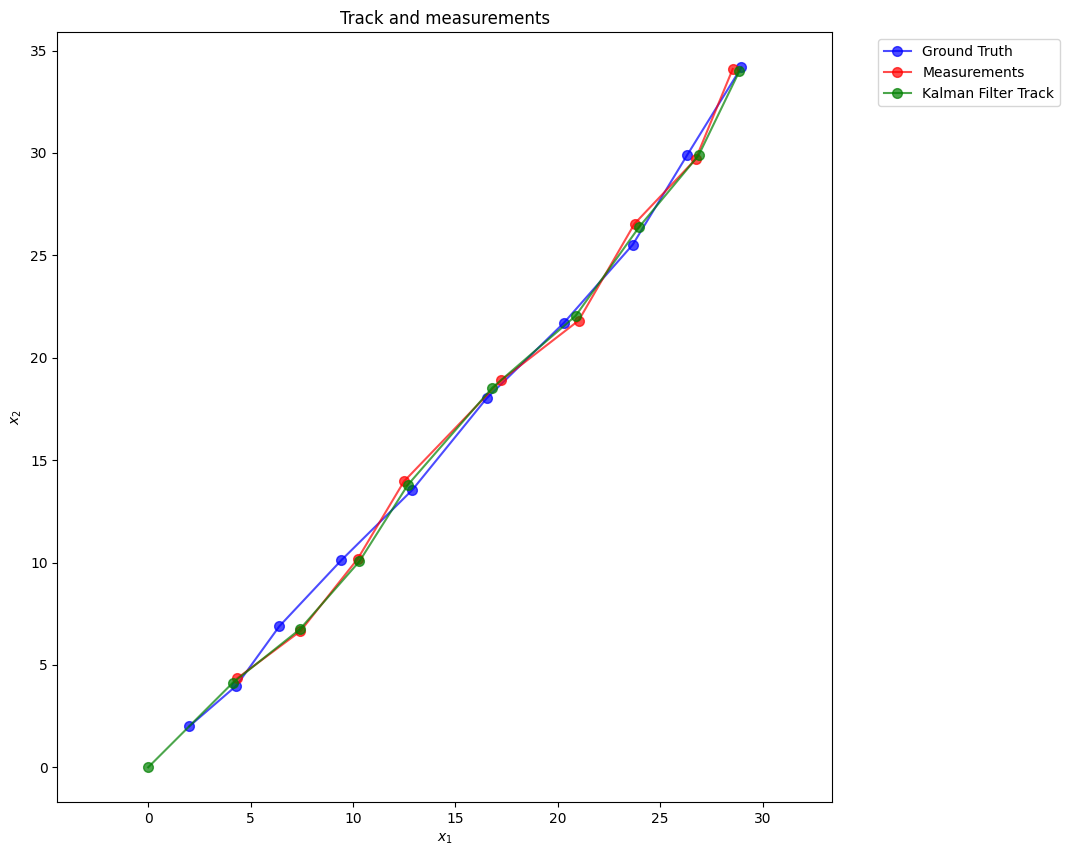

In [88]:
# now, the kalman filter will be applied to the simulation:
track = kalman_filter(x_init, x_cov, ms, Q, R, H, F)

# Visualize the results of the simulation and the kalman filter:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(gt[:, 0], gt[:, 1], c="b", label="Ground Truth", markersize=7, marker="o", alpha=0.7)
ax.plot(ms[:, 0], ms[:, 1], c="r", label="Measurements", markersize=7, marker="o", alpha=0.7)
ax.plot(track[:, 0], track[:, 1], c="g", label="Kalman Filter Track", markersize=7, marker="o", alpha=0.7)

ax.axis("equal")
plt.title("Track and measurements")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

---
### e) 
Write a function which calculates the root mean square error (RMSE) of $n=100$ simulation runs with the error as the Euclidean norm at the last time step.

In [89]:
n = 100

def RMSE(n, steps, x_init, x_cov, Q, R, H, F):
    """
    Function that calculates the RMSE of n simulation runs with a fixed number of steps each.
    
    :param n: number of simulation runs to perform
    :param steps: number of steps to run each simulation for
    :param x_init: Initial state for x
    :param x_cov: Initial covariance of x
    :param Q: transition noise matrix
    :param R: Measurement noise matrix
    :param H: measurement matrix
    :param F: state transition matrix
    
    :return: error, the RMSE over all runs
    """
    
    # === YOUR CODE HERE ===

    error = []
    for i in range(n):
        original_track, ms = simulation(x_init, x_cov, Q, R, H, F, steps)
        kalman_track = kalman_filter(x_init, x_cov, ms, Q, R, H, F)
        error.append((original_track[-1] - kalman_track[-1])**2)

    return np.sqrt(np.average(np.array(error)))
    
    # === END OF YOUR CODE ===
    
error = RMSE(n, steps, x_init, x_cov, Q, R, H, F)
print("RMSE over {} runs: {:.4f}".format(n, error))

RMSE over 100 runs: 0.4776


---
### f)
Finally, assume a worse sensor with noise covariance
$$
\textbf{R}_2=\begin{bmatrix}2.0 & 0\\0 & 0.2\end{bmatrix}\enspace.
$$
Calculate the RMSE as in e). To deal with the noise, add a second sensor. Assume the measurements to be independent of each other and update the simulation and Kalman filter accordingly and observe the difference in RMSE. Now, instead of using the same type of sensor, use the sensor with $\textbf{R}_2$ along a second sensor with noise covariance
$$
\textbf{R}_3=\begin{bmatrix}0.2 & 0\\0 & 2.0\end{bmatrix}\enspace.
$$

To this end, two variables need to be (re-)defined: $\textbf{R}$ and $\textbf{H}$\
To avoid confusion, the stacked versions of these variables will be called `R_stack` and `H_stack`.

In [90]:
# Please define R_stack according to the values given in the exercise
# === YOUR CODE HERE ===
# R_stack = ...
R_stack = [
    [2, 0, 0, 0],
    [0, 0.2, 0, 0],
    [0, 0, 0.2, 0],
    [0, 0, 0, 2],
]

print('R_stack: ', R_stack)


# === END OF YOUR CODE ===

R_stack = np.array(R_stack)
assert R_stack.shape == (4,4)

# H_stack is simply the vertically stacked version of H
H_stack = np.vstack((H,H))

R_stack:  [[2, 0, 0, 0], [0, 0.2, 0, 0], [0, 0, 0.2, 0], [0, 0, 0, 2]]


In [91]:
n = 100
# run the simulation, with the new R_stack consisting of the new sensors R2 and R3
error = RMSE(n, steps, x_init, x_cov, Q, R_stack, H_stack, F)
print("RMSE over {} runs: {:.4f}".format(n, error))

RMSE over 100 runs: 0.4878
